<a href="https://colab.research.google.com/github/GymYJ/RNN_time-series/blob/master/rnn_smp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install PyMySQL

     |████████████████████████████████| 51kB 1.1MB/s 


In [2]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import os
import datetime as dt
import pymysql.cursors

tf.set_random_seed(777)  # reproducibility

def MinMaxScaler(data):
    ''' Min Max Normalization
    Parameters
    ----------
    data : numpy.ndarray
        input data to be normalized
        shape: [Batch size, dimension]
    Returns
    ----------
    data : numpy.ndarry
        normalized data
        shape: [Batch size, dimension]
    References
    ----------
    .. [1] http://sebastianraschka.com/Articles/2014_about_feature_scaling.html
    '''
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator)


# train hyperParameters
seq_length = 7
data_dim = 24
hidden_dim = 495
output_dim = 24
learning_rate = 0.006
iterations = 125

# Open, Close
connection = pymysql.connect(host = '',
                             user = '',
                             password = '',
                             db = '',
                             charset = 'utf8mb4',
                             cursorclass = pymysql.cursors.DictCursor)

try:
    with connection.cursor() as cursor:
        sql = "SELECT * FROM SMP_TB"
        cursor.execute(sql)
        result = cursor.fetchall()
        
        data = []
        datetime = 0
        row_tmp = []
        for row_data in result:
            datetime = row_data['SMP_YMD']
            for i in range(1,25):
                row_tmp.append(row_data['t_'+str(i)+'H'])
            data.append(row_tmp)
            row_tmp = []
        data.append([80]*24)
        xy = np.array(data).astype(np.float)
finally:
    connection.close()

# train/test split
train_size = int(len(xy)*0.7)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]  # Index from [train_size - seq_length] to utilize past sequence

datetime = int(datetime)
Year = datetime // 10000
Month = (datetime % 10000) // 100
Day = datetime % 100
datetime = dt.date(Year, Month, Day)
datetime = datetime + dt.timedelta(days=1)
datetime = str("%d%02d%02d" % (datetime.year, datetime.month, datetime.day))

print(datetime)
print(len(xy))
print(len(train_set))
print(len(test_set))
train_set.shape

20200104
1465
1025
447


(1025, 24)

In [3]:

# Scale each
save_train = train_set
save_test = test_set
train_set = MinMaxScaler(train_set)
test_set = MinMaxScaler(test_set)

# build datasets
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, :]
        #print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

print("build datasets done")


build datasets done


In [0]:
class EarlyStopping():
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience  = patience
        self.verbose = verbose

    def validate(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print(f'Training process is stopped early....')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False

In [5]:
step = 0
while step < 100:
    
    tf.reset_default_graph()
    # input place holders
    X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
    Y = tf.placeholder(tf.float32, [None, 24])

    # build a LSTM network
    cell = tf.contrib.rnn.BasicLSTMCell(
        num_units=hidden_dim, state_is_tuple=True, activation=tf.nn.tanh)
    outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    Y_pred = tf.contrib.layers.fully_connected(
        outputs[:, -1], output_dim, activation_fn=None)  # We use the last cell's output

    # cost/loss
    loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
    # optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train = optimizer.minimize(loss)

    # RMSE
    targets = tf.placeholder(tf.float32, [None, 24])
    predictions = tf.placeholder(tf.float32, [None, 24])
    rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)

        early_stopping = EarlyStopping(patience=20, verbose=1)
        saver = tf.train.Saver()
        # Training step
        step = 0
        for i in range(iterations):
            _, step_loss = sess.run([train, loss], feed_dict={
                                    X: trainX, Y: trainY})
            test_predict = sess.run(Y_pred, feed_dict={X: testX})
            rmse_val = sess.run(rmse, feed_dict={
                targets: testY, predictions: test_predict})
            print("[step: {}] train_loss: {} \t test_RMSE: {}".format(i, step_loss, rmse_val))
            step += 1
            if early_stopping.validate(rmse_val):
                break
            
        # saver.save(sess, save_path='/content/gdrive/My Drive/Colab Notebooks/lstm.model')


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `layer.__call__` method instead.
[step: 0] train_loss: 9117.890625 	 test_RMSE: 0.866325855255127
[step: 1] train_loss: 23318.05859375 	 test_RMSE: 0.778617262840271
[step: 2] train_

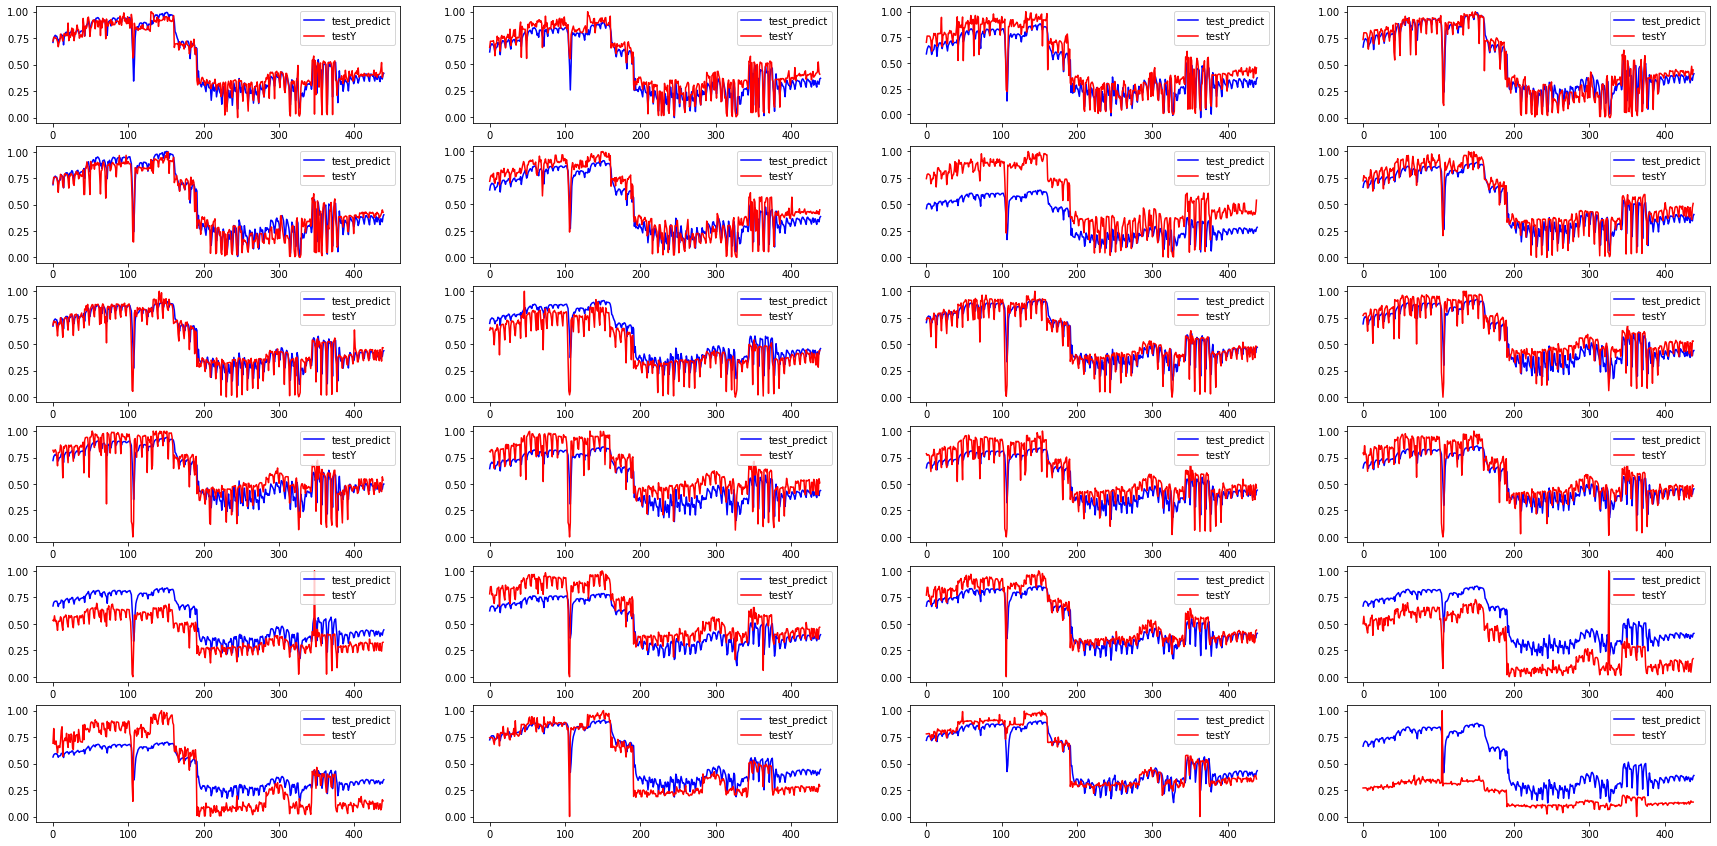

In [6]:
import matplotlib.pyplot as plt

# Plot predictions
plt.figure(figsize=(30, 15))
#test_predict = MinMaxScaler(test_predict) # predict 값 0~1로 맞추기
for i in range(24):
    plt.subplot(6,4,i+1)
    plt.plot(test_predict[:,i], c='blue', label='test_predict')
    plt.plot(testY[:-1,i], c='red', label='testY')
    plt.legend()
plt.show()

In [0]:
def invertMinMaxScaler(data, scale):
    denominator = np.max(data, 0) - np.min(data, 0)
    return (scale * (denominator)) + np.min(data, 0)

In [8]:
invertPredict = invertMinMaxScaler(save_test, test_predict)
invertReal = invertMinMaxScaler(save_test, test_set)
invertValue = []
print("scaled value\n")
for i in range(24):
    print("[%d h] - scaled: %f invert scaled: %f" % (i+1, test_predict[-1,i], invertPredict[-1,i]))
    invertValue.append(float("%.2f" % (float(invertPredict[-1,i]))))

scaled value

[1 h] - scaled: 0.418477 invert scaled: 82.790927
[2 h] - scaled: 0.366001 invert scaled: 79.432671
[3 h] - scaled: 0.355662 invert scaled: 77.189477
[4 h] - scaled: 0.414723 invert scaled: 79.382517
[5 h] - scaled: 0.404088 invert scaled: 79.993198
[6 h] - scaled: 0.385019 invert scaled: 78.994175
[7 h] - scaled: 0.284415 invert scaled: 73.981300
[8 h] - scaled: 0.405158 invert scaled: 82.674229
[9 h] - scaled: 0.438344 invert scaled: 87.388493
[10 h] - scaled: 0.458667 invert scaled: 91.214367
[11 h] - scaled: 0.470960 invert scaled: 87.237249
[12 h] - scaled: 0.440320 invert scaled: 81.815185
[13 h] - scaled: 0.499772 invert scaled: 82.761477
[14 h] - scaled: 0.438270 invert scaled: 80.499292
[15 h] - scaled: 0.442398 invert scaled: 84.002441
[16 h] - scaled: 0.453778 invert scaled: 85.184942
[17 h] - scaled: 0.442672 invert scaled: 97.800148
[18 h] - scaled: 0.396971 invert scaled: 83.841689
[19 h] - scaled: 0.410007 invert scaled: 86.254877
[20 h] - scaled: 0.409299 

In [0]:
import pymysql.cursors

connection = pymysql.connect(host = '',
                             user = '',
                             password = '',
                             db = '',
                             charset = 'utf8mb4',
                             cursorclass = pymysql.cursors.DictCursor)

try:
    with connection.cursor() as cursor:
        sql = """
            INSERT INTO SMP_PRED (SMP_YMD, t_1H, t_2H, t_3H, t_4H, t_5H, t_6H, 
            t_7H, t_8H, t_9H, t_10H, t_11H, t_12H, t_13H, t_14H, t_15H, t_16H, 
            t_17H, t_18H, t_19H, t_20H, t_21H, t_22H, t_23H, t_24H) 
            VALUES (%s, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f)
            """
        cursor.execute(sql % (datetime, invertValue[0], invertValue[1], invertValue[2], invertValue[3], invertValue[4], invertValue[5]
                             , invertValue[6], invertValue[7], invertValue[8], invertValue[9], invertValue[10], invertValue[11]
                             , invertValue[12], invertValue[13], invertValue[14], invertValue[15], invertValue[16], invertValue[17]
                             , invertValue[18], invertValue[19], invertValue[20], invertValue[21], invertValue[22], invertValue[23]))
        connection.commit()
        prind("commit complete")
finally:
    connection.close()
    prind("complete")

In [10]:
!pip install elasticsearch

     |████████████████████████████████| 92kB 2.1MB/s 


In [11]:
from elasticsearch import Elasticsearch

es = Elasticsearch('')
es.info()

{'cluster_name': 'docker-cluster',
 'cluster_uuid': 'YF7f6Yj2RYe_ZB2nAl7iJA',
 'name': 'test-synergy-elastic',
 'tagline': 'You Know, for Search',
 'version': {'build_date': '2019-11-26T01:06:52.518245Z',
  'build_flavor': 'default',
  'build_hash': 'e9ccaed468e2fac2275a3761849cbee64b39519f',
  'build_snapshot': False,
  'build_type': 'docker',
  'lucene_version': '8.3.0',
  'minimum_index_compatibility_version': '6.0.0-beta1',
  'minimum_wire_compatibility_version': '6.8.0',
  'number': '7.5.0'}}

In [0]:
doc = {
    "mappings": {
        "properties": {
            "date": {"type": "date", "format": "yyyy-MM-dd'T'HH"},
            "real_price": {"type": "double"},
            "pred_price": {"type": "double"}
        }        
    }
}

In [0]:
#es.indices.create(index="smp", body=doc) #처음 index 만들 때만 사용하고 이후엔 사용안함

In [0]:
for i in range(0,24):
    date = datetime[0:4]+"-"+datetime[4:6]+"-"+datetime[6:8]+"T"+str("%02d" % (i))
    body = {
        "date": date,
        "real_price": 0,
        "pred_price": invertValue[i],
    }
    res = es.index(index="smp", id=date, body=body)
    print(i, res['result'])